<a href="https://colab.research.google.com/github/FirasBellakhel/-CodeClause_Brain-Tumor-Detection-with-Data-Science/blob/main/projet_tumeur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import os
import glob
import shutil
import random
import pandas as pd
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/MyDrive/braintumor"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
dataset  no  pred  yes


In [19]:
import glob
import pandas as pd

def import_data(path):
    filenames = glob.glob(path)
    return filenames

# Define the paths to the datasets
healthy_brain_path = '/content/drive/MyDrive/braintumor/no/*.jpg'
tumor_brain_path = '/content/drive/MyDrive/braintumor/yes/*.jpg'
test_path = '/content/drive/MyDrive/braintumor/pred/*.jpg'

# Import the data from the paths
healthy_brain_files = import_data(healthy_brain_path)
tumor_brain_files = import_data(tumor_brain_path)
test_files = import_data(test_path)

# Create dataframes for each dataset
healthy_brain_df = pd.DataFrame({'image': healthy_brain_files, 'label': 'Healthy'})
tumor_brain_df = pd.DataFrame({'image': tumor_brain_files, 'label': 'Affected'})
test_df = pd.DataFrame({'image': test_files})

# Combine the datasets into one dataframe
train_data = pd.concat([healthy_brain_df, tumor_brain_df])


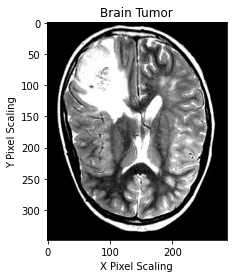

In [20]:
#a visualzation sample of the cancerous image 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


img_path = '/content/drive/MyDrive/braintumor/yes/y0.jpg'

img = mpimg.imread(img_path)

fig, ax = plt.subplots()
ax.imshow(img)
ax.set_title("Brain Tumor")
ax.set_xlabel("X Pixel Scaling")
ax.set_ylabel("Y Pixel Scaling")
plt.show()


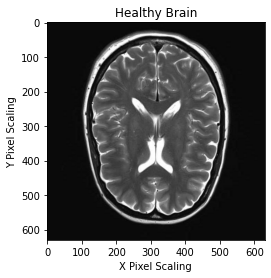

In [21]:
#a visualzation sample of a non cancerous image 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = '/content/drive/MyDrive/braintumor/no/No12.jpg'

img = mpimg.imread(img_path)

fig, ax = plt.subplots()
ax.imshow(img)
ax.set_title("Healthy Brain")
ax.set_xlabel("X Pixel Scaling")
ax.set_ylabel("Y Pixel Scaling")
plt.show()


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(train_data,
                                  test_size = 0.1,
                                  shuffle = True,
                                  random_state = 42)

In [23]:
import keras
from keras.metrics import AUC, Recall, Precision
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D , MaxPooling2D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import RMSprop

In [24]:
#Sequential Model creation

def build_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(224, 224, 1)))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(128, (5, 5), activation='relu'))
    model.add(Conv2D(128, (5, 5), activation='relu'))
    model.add(Conv2D(256, (5, 5), activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2, activation='softmax'))
    return model

model = build_model()
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 220, 220, 64)      1664      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 106, 106, 128)     204928    
                                                                 
 conv2d_22 (Conv2D)          (None, 102, 102, 128)     409728    
                                                                 
 conv2d_23 (Conv2D)          (None, 98, 98, 256)       819456    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 49, 49, 256)      0         
 g2D)                                                 

In [25]:
#%% FITTING THE MODEL

def Model_fit(train_data, val_data):
    model = build_model()
    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    callbacks = [EarlyStopping(monitor='val_loss', patience=2),
                 ModelCheckpoint("Brain_model_best.h5", save_best_only=True),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)]
    history = model.fit(train_data, validation_data=val_data, epochs=50, batch_size=10, callbacks=callbacks)
    return history


In [26]:
#training of the model
from keras.preprocessing.image import ImageDataGenerator

k_fold = 3
IMG_SIZE = 224
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2

def CV_training(train_data, val_data):
    
    cv_histories = []
    
    for i in range(0,k_fold):
    
        datagen = ImageDataGenerator(rescale = 1./255)
    
        train_set = datagen.flow_from_dataframe(train_data,
                                                directory = '/content/drive/MyDrive/braintumor/dataset/*.jpg',
                                                x_col = 'image',
                                                y_col = 'label',
                                                target_size = size,
                                                color_mode = 'grayscale',
                                                class_mode = 'sparse',
                                                batch_size = 10,
                                                shuffle = True,
                                                interpolation = 'bilinear')
        
        val_set = datagen.flow_from_dataframe(val_data,
                                              directory = '/content/drive/MyDrive/braintumor/dataset/*.jpg',
                                              x_col = 'image',
                                              y_col = 'label',
                                              target_size = size,
                                              color_mode = 'grayscale',
                                              class_mode = 'sparse',
                                              batch_size = 10,
                                              shuffle = True,
                                              interpolation = 'bilinear')
        print("Training on Fold: ",i+1)
    
        cv_histories.append(Model_fit(train_set, val_set))
    
    return cv_histories

cv_results = CV_training(X_train,X_val)

Found 2700 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
Training on Fold:  1
Epoch 1/50
270/270 [==============================] - 35s 127ms/step - loss: 1.9030 - accuracy: 0.6219 - val_loss: 0.5353 - val_accuracy: 0.7033 - lr: 0.0010
Epoch 2/50
270/270 [==============================] - 33s 123ms/step - loss: 0.6603 - accuracy: 0.7644 - val_loss: 0.3347 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 3/50
270/270 [==============================] - 34s 124ms/step - loss: 0.4895 - accuracy: 0.8507 - val_loss: 0.2654 - val_accuracy: 0.8733 - lr: 0.0010
Epoch 4/50
270/270 [==============================] - 33s 123ms/step - loss: 0.2881 - accuracy: 0.9041 - val_loss: 0.1731 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 5/50
270/270 [==============================] - 34s 125ms/step - loss: 0.2084 - accuracy: 0.9389 - val_loss: 0.1528 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 6/50
270/270 [==============================] - 33s 121ms/step

In [27]:
def print_val_acc(results):
    for i, fold in enumerate(results):
        if 'val_accuracy' in fold.history:
            print(f'val_accuracy Fold {i} = {max(fold.history["val_accuracy"])}')
        else:
            print(f'val_accuracy not found for Fold {i}')

print_val_acc(cv_results)


val_accuracy Fold 0 = 0.9599999785423279
val_accuracy Fold 1 = 0.95333331823349
val_accuracy Fold 2 = 0.9666666388511658


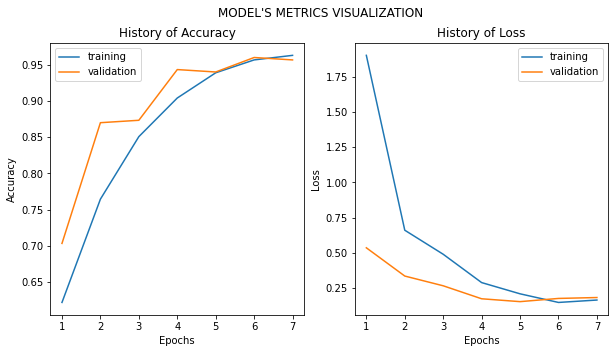

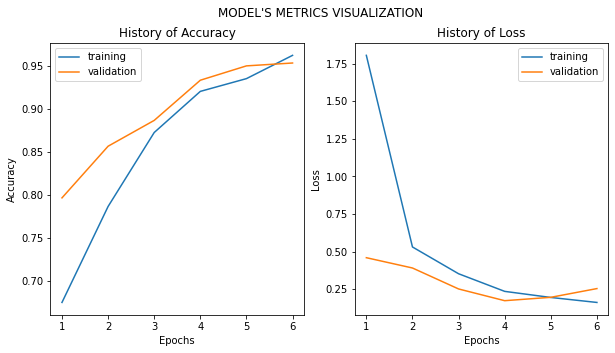

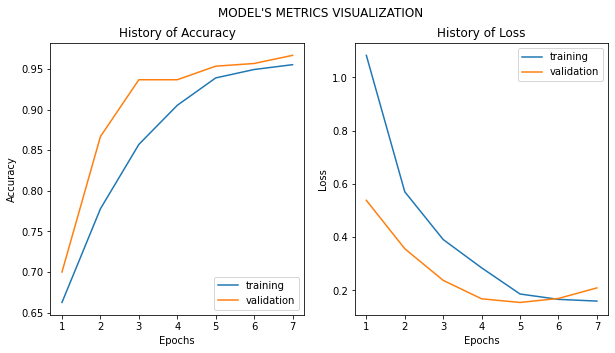

In [33]:
def plot_acc_loss(results):
    for fold in results:
        accuracy = fold.history['accuracy']
        val_acc = fold.history['val_accuracy']
        loss = fold.history['loss']
        val_loss = fold.history['val_loss']

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        fig.suptitle("MODEL'S METRICS VISUALIZATION")

        ax1.plot(range(1, len(accuracy) + 1), accuracy)
        ax1.plot(range(1, len(val_acc) + 1), val_acc)
        ax1.set_title('History of Accuracy')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Accuracy')
        ax1.legend(['training', 'validation'])

        ax2.plot(range(1, len(loss) + 1), loss)
        ax2.plot(range(1, len(val_loss) + 1), val_loss)
        ax2.set_title('History of Loss')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Loss')
        ax2.legend(['training', 'validation'])
        plt.show()

plot_acc_loss(cv_results)



In [40]:
import keras

model = keras.models.load_model('Brain_model_best.h5')
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test = gen.flow_from_dataframe(test_df, directory='/content/drive/MyDrive/braintumor/*.jpg', x_col='image',
                               y_col=None, target_size=size, color_mode='grayscale', class_mode=None,
                               batch_size=10, shuffle=False, interpolation='bilinear')

predictions = model.predict(test).argmax(axis=-1)
print("Where 0 = 'Affected'")
print("Where 1 = 'Healthy'")
print(predictions)


Found 60 validated image filenames.
6/6 [==============================] - 1s 85ms/step
Where 0 = 'Affected'
Where 1 = 'Healthy'
[1 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 0 1 0
 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1]


In [41]:
pred = []
[pred.append('Healthy') if i == 1 else pred.append('Affected') for i in predictions]
print(pred)

['Healthy', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Affected', 'Affected', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Affected', 'Affected', 'Affected', 'Affected', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Healthy']


In [44]:
images10 = test_set[0][0:9]
prediction10 = pred[0:9]
final_pred = zip(images10, prediction10)


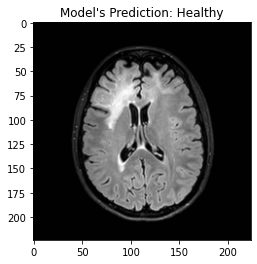

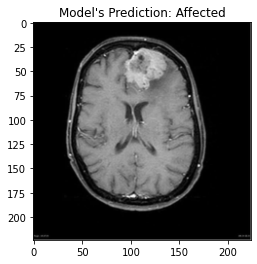

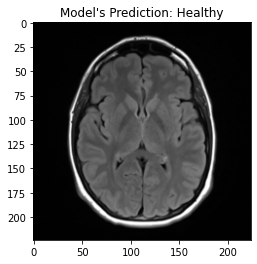

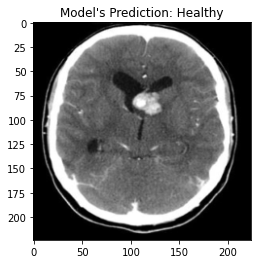

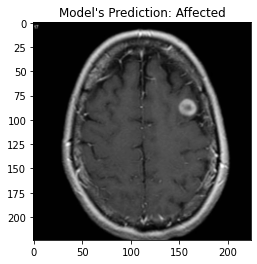

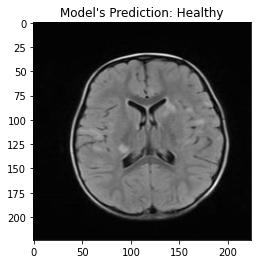

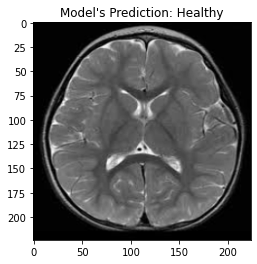

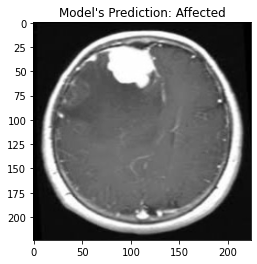

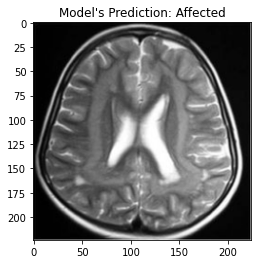

In [43]:
def pre_visualization(data, predictions):
    
    for image,pred in final_pred:
        plt.imshow(image.reshape(224,224), cmap = 'gray')
        plt.title("Model's Prediction: " + str(pred))
        plt.show()
        
pre_visualization(images10,prediction10)